In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from time import time

twenty_train = fetch_20newsgroups(subset='train', shuffle=True, remove = ('headers', 'footers'))
targets_train = twenty_train['target']

twenty_test = fetch_20newsgroups(subset = 'test', remove = ('headers', 'footers'))
targets_test = twenty_test['target']

groups = np.arange(20)
priori = np.mean(targets_train == groups.reshape(-1, 1), axis = 1)

#base = np.arange(targets_test.size)
#val_idx = np.random.choice(base, size = int(targets_test.size / 2), replace = False)
#test_idx = base[np.all(base != val_idx.reshape(-1, 1), axis = 0)]
#val_idx = [0]#np.arange(int(targets_test.size / 2))
test_idx = np.arange(targets_test.size)

def attempt(smoothing, max_weight, **kwargs):
    cv = CountVectorizer(**kwargs, stop_words = 'english')
    fitted = cv.fit_transform(twenty_train['data'])
    
    #f2 = fitted.toarray()
    #words = np.array(cv.get_feature_names())

    probabilities = np.zeros((20, fitted.shape[1]))
    
    df = fitted.getnnz(axis = 0) / targets_train.size
    plt.hist(df * 100, bins = 80)
    plt.yscale('log')
    plt.xlabel('%')
    plt.ylabel('Repeticiones')
   
    for group in groups:
        row = fitted[targets_train == group].sum(axis = 0) #+ smoothing
        probabilities[group] = row[0] / row.sum()
        
    #np.delete(f2)
    #del words
    print(probabilities)
    fitted_test = cv.transform(twenty_test['data'])#.toarray().T
        
    probs_test = fitted_test.dot(np.log(probabilities).T) + np.log(priori)

    pred_test = np.argmax(probs_test, axis = 1)

    acc_test = np.mean(pred_test == targets_test)
    
    return {'Test': (acc_test * 100).round(2)}

In [3]:
d = np.arange(.01, .15, .005)
s = np.arange(1e-3, .11, .01)

for df in d:
    for smooth in s:
        print(df, smooth)
        print(attempt(min_df = 1, max_df = df, smoothing = smooth, max_weight = 2.5))

0.01 0.001
{'Test': 72.73}
0.01 0.011
{'Test': 73.35}
0.01 0.020999999999999998
{'Test': 73.57}
0.01 0.030999999999999996
{'Test': 73.83}
0.01 0.040999999999999995
{'Test': 73.79}
0.01 0.05099999999999999
{'Test': 73.9}
0.01 0.06099999999999999
{'Test': 73.94}
0.01 0.071
{'Test': 73.98}
0.01 0.08099999999999999
{'Test': 74.03}
0.01 0.09099999999999998
{'Test': 73.99}
0.01 0.10099999999999998
{'Test': 73.99}
0.015 0.001
{'Test': 73.88}
0.015 0.011
{'Test': 74.71}
0.015 0.020999999999999998
{'Test': 74.92}
0.015 0.030999999999999996
{'Test': 75.08}
0.015 0.040999999999999995
{'Test': 75.15}
0.015 0.05099999999999999
{'Test': 75.23}
0.015 0.06099999999999999
{'Test': 75.24}
0.015 0.071
{'Test': 75.35}
0.015 0.08099999999999999
{'Test': 75.28}
0.015 0.09099999999999998
{'Test': 75.35}
0.015 0.10099999999999998
{'Test': 75.37}
0.019999999999999997 0.001
{'Test': 74.31}
0.019999999999999997 0.011
{'Test': 75.04}
0.019999999999999997 0.020999999999999998
{'Test': 75.31}
0.019999999999999997 0

In [6]:
from time import time

d = np.arange(.055, .075, .001)
s = np.array([.1])
w = np.array([2.5])

res = np.zeros((d.size, s.size, w.size))
tot = 0

for i, df in enumerate(d):
    for j, smooth in enumerate(s):
        for z, weight in enumerate(w):
            start = time()
            print(f'{i * s.size * w.size + j * s.size + z + 1} of {res.size}')
            res[i, j, z] = attempt(min_df = 1, max_df = df, smoothing = smooth, max_weight = weight)['Test']
            tot += time() - start
        
best = res.max()
argmax = np.argwhere(res == best)[0]
print(f'Best max_df: {d[argmax[0]]}')
print(f'Best smoothing: {s[argmax[1]]}')
print(f'Best weight: {w[argmax[2]]}')
print(f'Best result: {best}')
print(f'Time: {tot / (d.size * s.size * w.size)}')

1 of 20
2 of 20
3 of 20
4 of 20
5 of 20
6 of 20
7 of 20
8 of 20
9 of 20
10 of 20
11 of 20
12 of 20
13 of 20
14 of 20
15 of 20
16 of 20
17 of 20
18 of 20
19 of 20
20 of 20
Best max_df: 0.065
Best smoothing: 0.1
Best weight: 2.5
Best result: 0.7699150292087095
Time: 4.319996857643128


In [ ]:
sens_tot = []
especif_tot = []
vp_tot = []
vn_tot = []

for i in range(20):
    targets_ok = targets_test == i
    pred_ok = pred == i
    VP = np.sum(targets_ok & pred_ok)
    VN = np.sum(~targets_ok & ~pred_ok)
    FP = np.sum(~targets_ok & pred_ok)
    FN = np.sum(targets_ok & ~pred_ok)
    
    sens_tot.append(VP / (VP + FN))
    especif_tot.append(VN / (VN + FP))
    vp_tot.append(VP / (VP + FP))
    vn_tot.append(VN / (VN + FN))
    
print(f'Sensibilidad: {np.round(np.mean(sens_tot) * 100, 2)}%')

# No tiene sentido, porque son 20 clases. Obvio que va a dar alto.
print(f'Especificidad: {np.round(np.mean(especif_tot) * 100, 2)}%') 

print(f'Valor predictivo positivo: {np.round(np.mean(vp_tot) * 100, 2)}%')

# No tiene sentido, porque son 20 clases. Obvio que va a dar alto.
print(f'Valor predictivo negativo: {np.round(np.mean(vn_tot) * 100, 2)}%')

## Preguntas
- $\textbf{Parte 1}$:
    - ¿Va bien 79.3%?
    - ¿Qué más podemos hacer para subirlo?
    - ¿Está bien usar accuracy?
    - ¿Para las otras métricas está bien sacar el promedio?
    
- $\textbf{Parte 2}$:
    - ¿Podemos sacar el priori si da peores resultados?
    - ¿Está bien elegida la sensibilidad como métrica?
    - ¿Está bien reemplazar a los NaN por la media según la clase?    

In [ ]:
print(twenty_train['DESCR'])

In [ ]:
print(twenty_train['target_names'])

[[1.70201178e-05 1.98568041e-04 5.67337259e-06 ... 5.67337259e-06
  5.67337259e-06 5.67337259e-06]
 [1.72895715e-04 8.64478575e-05 5.76319050e-06 ... 5.76319050e-06
  5.76319050e-06 5.76319050e-06]
 [9.81804938e-05 1.90026762e-05 3.16711270e-06 ... 3.16711270e-06
  3.16711270e-06 3.16711270e-06]
 ...
 [3.51109726e-05 7.72441398e-04 8.77774315e-06 ... 4.38887158e-06
  4.38887158e-06 4.38887158e-06]
 [1.22497103e-04 2.96034667e-04 5.10404598e-06 ... 5.10404598e-06
  5.10404598e-06 5.10404598e-06]
 [2.43666202e-05 1.03558136e-04 6.09165504e-06 ... 6.09165504e-06
  6.09165504e-06 6.09165504e-06]]


{'Test': 75.09}

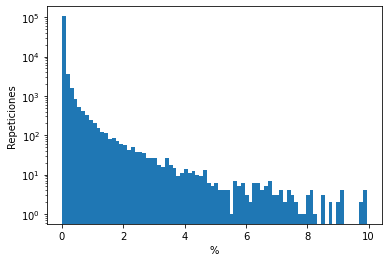

In [6]:
attempt(min_df = 1, max_df = .1, max_weight = 2.5, smoothing = .1)